In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import keras_nlp

2024-11-21 03:43:02.759892: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732135382.776109  106644 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732135382.781171  106644 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 03:43:02.805321: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ryanfikri/anaconda3/envs/capstone-project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not foun

In [66]:
with open("data/a/cleaned_data.csv", 'r') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"The second line (first data point) looks like this:\n\n{csvfile.readline()}")
    print(f"The third line (first data point) looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

statement,status

The second line (first data point) looks like this:

chronic stress help really wish anyone can help just wanna know anyone experiencing things havent found anyone im getting headaches migraines every single day around 2 months now isnt first time happened happened 2 years ago thing migraines every single day non stop like year straight point couldnt even eat developed photophobia couldtn even turn room lights anything eventually went away couple months im back doctors tell stress anxiety just doesnt make sense gets bad point cant even get bed awake long hours feeling pain no one gets bad long 7 months non stop started around november panic attacks anxiety usually something triggers anxiety can control no not time happens even im happy nowhere just feel bad time super weak progressed feeling okay morning bad night always knew id feel bad night daily duties day progressed even started getting migraines headaches every day light sta

In [67]:
VOCAB_SIZE = 10000
MAX_LENGTH = 500
TRAINING_SPLIT = 0.8
BATCH_SIZE = 32
PADDING_TYPE = 'post'
TRUNC_TYPE = 'post'
FILENAME = "data/a/cleaned_data.csv"

In [68]:
sentences = []
labels = []

with open(FILENAME, 'r') as csvfile:
    heading = next(csvfile)
    reader_obj = csv.reader(csvfile) 
    for row in reader_obj: 
        labels.append(row[1])
        sentences.append(row[0])

In [69]:
sequence_lengths = [len(sentence.split()) for sentence in sentences]
print("Mean length:", np.mean(sequence_lengths))
print("Median length:", np.median(sequence_lengths))
print("90th percentile:", np.percentile(sequence_lengths, 90))

Mean length: 168.68357142857144
Median length: 147.0
90th percentile: 320.0


In [70]:
dataset = tf.data.Dataset.from_tensor_slices((sentences, labels))

In [71]:
train_size = int(len(sentences) * TRAINING_SPLIT)
train_dataset = dataset.take(train_size)
validation_dataset = dataset.skip(train_size)

print(f"There are {train_dataset.cardinality()} sentence-label pairs for training.\n")
print(f"There are {validation_dataset.cardinality()} sentence-label pairs for validation.\n")

train_statement = train_dataset.map(lambda statement, status: statement)
train_labels = train_dataset.map(lambda statement, status: status)

test_statement = validation_dataset.map(lambda statement, status: statement)
test_labels = validation_dataset.map(lambda statement, status: status)

There are 4480 sentence-label pairs for training.

There are 1120 sentence-label pairs for validation.



In [8]:
# clean memory
del sentences
del labels
del dataset

In [72]:
# adapt
keras_nlp.tokenizers.compute_word_piece_vocabulary(
    train_statement,
    vocabulary_size=VOCAB_SIZE,
    reserved_tokens=["[PAD]", "[UNK]"],
    vocabulary_output_file='mental_vocab_subwords.txt'
)

# Initialize the subword tokenizer
vectorizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary='./mental_vocab_subwords.txt'
)

# # skip adapt
# # Load the vocabulary from the file
# with open("vocabulary.txt", "r") as f:
#     vocab = [line.strip() for line in f]

# # Reinitialize the vectorizer and set the vocabulary directly
# vectorizer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=MAX_LENGTH, output_mode="int")
# vectorizer.set_vocabulary(vocab)

vocab_size = vectorizer.vocabulary_size()
print(f"Vocabulary contains {vocab_size} words\n")

Vocabulary contains 7292 words



In [73]:
def fit_label_encoder(train_labels, validation_labels):
    """Creates an instance of a StringLookup, and trains it on all labels

    Args:
        train_labels (tf.data.Dataset): dataset of train labels
        validation_labels (tf.data.Dataset): dataset of validation labels

    Returns:
        tf.keras.layers.StringLookup: adapted encoder for train and validation labels
    """
    # join the two label datasets
    labels = train_labels.concatenate(validation_labels) #concatenate the two datasets.
    
    # Instantiate the StringLookup layer. Remember that you don't want any OOV tokens
    label_encoder = tf.keras.layers.StringLookup(num_oov_indices=0)
    
    # Fit the TextVectorization layer on the train_labels
    label_encoder.adapt(labels)
   
    return label_encoder

In [74]:
# Create the label encoder
label_encoder = fit_label_encoder(train_labels,test_labels)
                                  
print(f'Unique labels: {label_encoder.get_vocabulary()}')

Unique labels: ['Suicidal', 'Stress', 'Personality disorder', 'Normal', 'Depression', 'Bipolar', 'Anxiety']


2024-11-21 04:52:02.714127: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [75]:
def padding_func(sequences):
  '''Generates padded sequences from a tf.data.Dataset'''

  # Put all elements in a single ragged batch
  sequences = sequences.ragged_batch(batch_size=sequences.cardinality())

  # Output a tensor from the single batch
  sequences = sequences.get_single_element()

  # Pad the sequences
  padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(), 
                                                  maxlen=MAX_LENGTH, 
                                                  truncating=TRUNC_TYPE, 
                                                  padding=PADDING_TYPE
                                                 )

  # Convert back to a tf.data.Dataset
  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)

  return padded_sequences

In [76]:
# Preprocess dataset
SHUFFLE_BUFFER_SIZE = 10000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Generate integer sequences using the subword tokenizer
train_sequences_subword = train_statement.map(lambda statement: vectorizer.tokenize(statement)).apply(padding_func)
test_sequences_subword = test_statement.map(lambda statement: vectorizer.tokenize(statement)).apply(padding_func)

train_labels_encoded = train_labels.map(lambda label: label_encoder(label))
test_labels_encoded = test_labels.map(lambda label: label_encoder(label))

# Combine the integer sequence and labels
train_dataset_vectorized = tf.data.Dataset.zip(train_sequences_subword,train_labels_encoded)
test_dataset_vectorized = tf.data.Dataset.zip(test_sequences_subword,test_labels_encoded)

# Optimize the datasets for training
train_dataset_final = (train_dataset_vectorized
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .cache()
                       .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )


print(f"Number of batches in the train dataset: {train_dataset_final.cardinality()}")
print(f"Number of batches in the validation dataset: {test_dataset_final.cardinality()}")

Number of batches in the train dataset: 140
Number of batches in the validation dataset: 35


In [77]:
train_batch = next(train_dataset_final.as_numpy_iterator())
validation_batch = next(test_dataset_final.as_numpy_iterator())

print(f"Shape of the train batch: {train_batch[0].shape}")
print(f"Shape of the validation batch: {validation_batch[0].shape}")

Shape of the train batch: (32, 500)
Shape of the validation batch: (32, 500)


2024-11-21 04:52:13.174750: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-11-21 04:52:13.194631: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [ ]:
# Hyperparameters
EMBEDDING_DIM = 64
LSTM1_DIM = 16  # Reduce dimensions
LSTM2_DIM = 8
DENSE_DIM = 32

model = tf.keras.Sequential([ 
    tf.keras.Input(shape=(None,)),
    tf.keras.layers.Embedding(vectorizer.vocabulary_size(), EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM1_DIM, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM2_DIM, dropout=0.3, recurrent_dropout=0.3)),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'] 
) 

In [89]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, None, 64)       │       466,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, None, 32)       │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 478,343 (1.82 MB)

 Trainable params: 478,343 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

In [90]:
example_batch = train_dataset_final.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (32, 7)


In [91]:
history = model.fit(train_dataset_final, epochs=30, validation_data=test_dataset_final)

Epoch 1/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.1718 - loss: 1.9262 - val_accuracy: 0.4089 - val_loss: 1.4753
Epoch 2/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.3922 - loss: 1.4216 - val_accuracy: 0.6036 - val_loss: 1.1306
Epoch 3/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.5319 - loss: 1.1070 - val_accuracy: 0.6366 - val_loss: 0.9105
Epoch 4/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - accuracy: 0.5734 - loss: 0.9277 - val_accuracy: 0.6286 - val_loss: 0.8963
Epoch 5/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.6185 - loss: 0.8264 - val_accuracy: 0.6000 - val_loss: 0.9196
Epoch 6/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.6479 - loss: 0.7910 - val_accuracy: 0.6321 - val_loss: 0.8838
Epoch 7/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.6746 - loss: 0.7041 - val_accuracy: 0.6313 - val_loss: 0.8679
Epoch 8/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.7187 - loss: 0.6578 - v

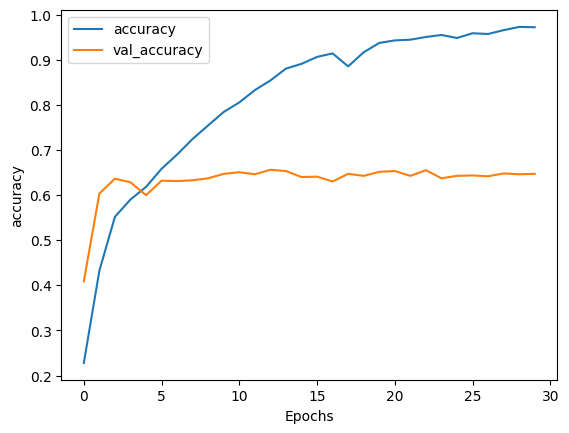

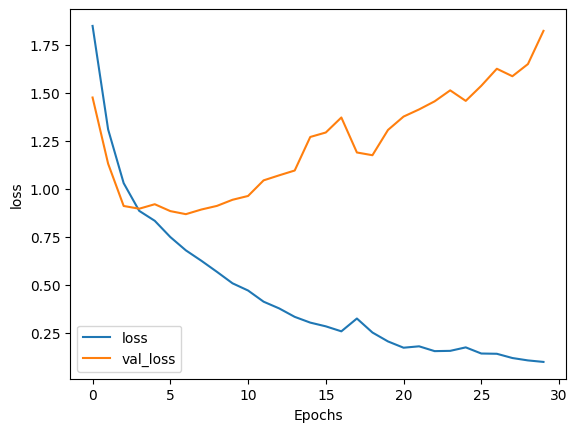

In [92]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [39]:
# Get the vocabulary
imdb_vocab_fullword = vectorizer.get_vocabulary()

# Define sample sentence
sample_string = "I can't take it anymore"

# Encode using the plain text tokenizer
tokenized_string = vectorizer(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

# Decode and print the result
decoded_text = [imdb_vocab_fullword[token] for token in tokenized_string]
original_string = ' '.join(decoded_text)
print ('The original string: {}'.format(original_string))

Tokenized string is [  1  83   1  21 140  10 325 163]
The original string: [UNK] can [UNK] t take i ##t anymore


In [65]:
rawtext_test = ["fuck you all, i can't take it anymore"]
sequence_test = padding_func(tf.data.Dataset.from_tensors(vectorizer.tokenize(rawtext_test)))
for element in sequence_test:
    print(element)
predictions = model.predict(sequence_test)

# predictions will be a numpy array of shape (1, num_classes) with probabilities for each class
print(predictions)

# To get the predicted class index
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
print(f"Predicted class: {label_encoder.get_vocabulary()[predicted_class_index]}")

tf.Tensor(
[[ 357 2387 1429 ...   10  325  163]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]], shape=(500, 14), dtype=int32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[[2.0915571e-01 6.7480721e-02 1.6460376e-03 ... 9.0808749e-02
  6.6269815e-02 4.9865472e-01]
 [1.1240889e-07 5.6689983e-06 9.9981564e-01 ... 5.5694773e-07
  2.0144377e-09 5.4560768e-08]
 [1.1240889e-07 5.6689983e-06 9.9981564e-01 ... 5.5694773e-07
  2.0144377e-09 5.4560768e-08]
 ...
 [1.1240889e-07 5.6689983e-06 9.9981564e-01 ... 5.5694773e-07
  2.0144377e-09 5.4560768e-08]
 [1.1240889e-07 5.6689983e-06 9.9981564e-01 ... 5.5694773e-07
  2.0144377e-09 5.4560768e-08]
 [1.1240889e-07 5.6689983e-06 9.9981564e-01 ... 5.5694773e-07
  2.0144377e-09 5.4560768e-08]]
Predicted class: Anxiety


In [55]:
model.save('first_iteration.keras')